# **INFO284 Machine Learning Exam, spring 2025**


# **Task 1 - Sentiment analysis**

## **Load data**

In [19]:
import pandas as pd

df = pd.read_csv('dataset/Hotel_Reviews.csv')

df.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968


## **Exploring the data**

We get an overview of the data to find out the max and min values of the reviewer scores and to get an idea of the distribution of the scores.

count    515738.000000
mean          8.395077
std           1.637856
min           2.500000
25%           7.500000
50%           8.800000
75%           9.600000
max          10.000000
Name: Reviewer_Score, dtype: float64
115853
253


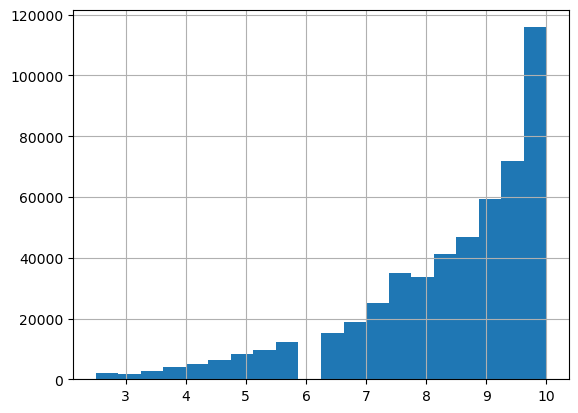

In [20]:
print(df['Reviewer_Score'].describe()) 

df['Reviewer_Score'].hist(bins=20) # 20 bins

print(df[df['Reviewer_Score'] == 10.0].shape[0])
print(df[df['Reviewer_Score'] == 6.0].shape[0])

Relevant columns are negative and positive reviews. We need to combine them to make it easier to work with the data.

## **Cleaning the review text**

Here we clean the review text. We remove 'No Negative' and 'No Positive' from the negative and positive reviews. 
Then we merge the negative and positive reviews into one column called 'Review'. 
Then we only keep the 'Review' and 'Reviewer_Score' columns because they are the only relevant columns for the sentiment analysis. All other columns are dropped.
We also remove rows with missing values because they are not useful for the sentiment analysis.

In [21]:
df['Negative_Review'] = df['Negative_Review'].apply(lambda x: x.replace('No Negative', ''))
df['Positive_Review'] = df['Positive_Review'].apply(lambda x: x.replace('No Positive', ''))

df['Review'] = df['Negative_Review'] + ' ' + df['Positive_Review']

df = df[['Review','Reviewer_Score']] 

df = df.dropna()

df.head()

,Review,Reviewer_Score
0,I am so angry that i made this post available...,2.9
1,No real complaints the hotel was great great...,7.5
2,Rooms are nice but for elderly a bit difficul...,7.1
3,My room was dirty and I was afraid to walk ba...,3.8
4,You When I booked with your company on line y...,6.7


## **Transforming review scores to binary values**

Here we add a new column called 'Sentiment' which is 1 if the reviewer score is greater than 5 and 0 otherwise. This is done to make it easier to work with the data in the sentiment analysis. 

In [22]:
# Adjust the reviewer score to be binary numeric values
df['Sentiment'] = df['Reviewer_Score'].apply(lambda x: 1 if x >= 7.0 else 0)

# Here we split the data into two dataframes based on the sentiment 
df_majority = df[df['Sentiment'] == 1]
df_minority = df[df['Sentiment'] == 0]

## **Adjusting for sentiment imbalance**
There is a heavy overweight of positive ('high' scores) in the dataset, so we need to downsample the positive reviews to get a more balanced dataset for our machine learning model to train and test on. By balancing the number of positive and negative reviews, we avoid the model being biased towards predicting the majority class which is positive reviews.

In [23]:
# Downsample majority class
df_majority_downsampled = df_majority.sample(len(df_minority))

# Combine minority class with downsampled majority class
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)

df = df_balanced

## **Eploring the data after downsampling the positive reviews**

count    173702.000000
mean          7.228931
std           2.045716
min           2.500000
25%           5.800000
50%           6.950000
75%           9.200000
max          10.000000
Name: Reviewer_Score, dtype: float64
23624
253


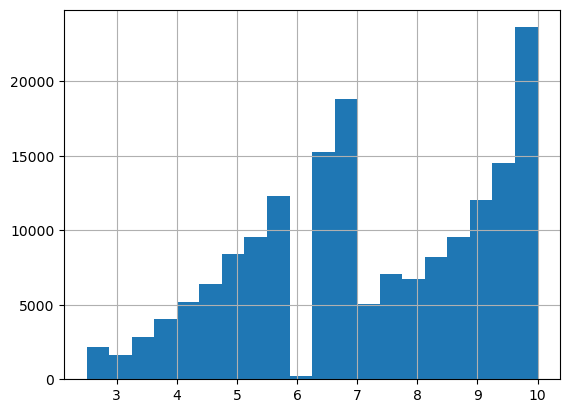

In [24]:
df['Reviewer_Score'].hist(bins=20) # 20 bins
print(df['Reviewer_Score'].describe()) 
print(df[df['Reviewer_Score'] == 10.0].shape[0])
print(df[df['Reviewer_Score'] == 6.0].shape[0])
# 115853
# 253

From the plot we can see that the number of positive and negative reviews are now more balanced. This is good because it will make the machine learning model less biased towards predicting the majority class which is positive reviews. 

## **Preprocessing the review text**

Here we preprocess the review text by lowercasing the text, removing special characters, punctuation using regular expressions, and removing stopwords. We also tokenize and lemmatize the text.

In [25]:
import re

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'@[A-Za-z0-9_]+', '', text) 
    text = re.sub(r'[^\w\s]', '', text)
    return text

df['Review'] = df['Review'].apply(preprocess_text)
df.head()

,Review,Reviewer_Score,Sentiment
0,the bed was slightly hard for my taste nice ...,7.1,1
1,hotel makes noise via vacuum cleaner or clean...,8.8,1
2,the best hotel in this price wonderful staff...,9.6,1
3,there wasn t anything to dislike the locati...,10.0,1
4,location quiet,6.3,0


### Removing stopwords

In [26]:
import nltk

from nltk.corpus import stopwords
 
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
pattern = r'\b(' + '|'.join(re.escape(word) for word in stop_words) + r')\b'

def remove_stopwords_regex(text):
    if isinstance(text, str):  
        return re.sub(pattern, '', text)  
    return text

df["Review"] = df["Review"].apply(remove_stopwords_regex)
df["Review"] = df["Review"].str.replace(r'\s+', ' ', regex=True).str.strip()
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mathiashandeland/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,Review,Reviewer_Score,Sentiment
0,bed slightly hard taste nice bar restaurant mu...,7.1,1
1,hotel makes noise via vacuum cleaner cleaning ...,8.8,1
2,best hotel price wonderful staff nice breakfas...,9.6,1
3,anything dislike location everything excellent...,10.0,1
4,location quiet,6.3,0


### Tokenization

In [27]:
from nltk.tokenize import word_tokenize

def tokenize(text):
    return word_tokenize(text)

df['tokens'] = df['Review'].apply(tokenize)
df.head()

,Review,Reviewer_Score,Sentiment,tokens
0,bed slightly hard taste nice bar restaurant mu...,7.1,1,"[bed, slightly, hard, taste, nice, bar, restau..."
1,hotel makes noise via vacuum cleaner cleaning ...,8.8,1,"[hotel, makes, noise, via, vacuum, cleaner, cl..."
2,best hotel price wonderful staff nice breakfas...,9.6,1,"[best, hotel, price, wonderful, staff, nice, b..."
3,anything dislike location everything excellent...,10.0,1,"[anything, dislike, location, everything, exce..."
4,location quiet,6.3,0,"[location, quiet]"


### Stemming

In [28]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

def stem(tokens):
    return [stemmer.stem(token) for token in tokens]

df['stemmed'] = df['tokens'].apply(stem)

df.head()

,Review,Reviewer_Score,Sentiment,tokens,stemmed
0,bed slightly hard taste nice bar restaurant mu...,7.1,1,"[bed, slightly, hard, taste, nice, bar, restau...","[bed, slightli, hard, tast, nice, bar, restaur..."
1,hotel makes noise via vacuum cleaner cleaning ...,8.8,1,"[hotel, makes, noise, via, vacuum, cleaner, cl...","[hotel, make, nois, via, vacuum, cleaner, clea..."
2,best hotel price wonderful staff nice breakfas...,9.6,1,"[best, hotel, price, wonderful, staff, nice, b...","[best, hotel, price, wonder, staff, nice, brea..."
3,anything dislike location everything excellent...,10.0,1,"[anything, dislike, location, everything, exce...","[anyth, dislik, locat, everyth, excel, hotel, ..."
4,location quiet,6.3,0,"[location, quiet]","[locat, quiet]"


### Lemmatization

In [29]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def lemmatize(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

df['lemmatized'] = df['tokens'].apply(lemmatize)

df.head()

,Review,Reviewer_Score,Sentiment,tokens,stemmed,lemmatized
0,bed slightly hard taste nice bar restaurant mu...,7.1,1,"[bed, slightly, hard, taste, nice, bar, restau...","[bed, slightli, hard, tast, nice, bar, restaur...","[bed, slightly, hard, taste, nice, bar, restau..."
1,hotel makes noise via vacuum cleaner cleaning ...,8.8,1,"[hotel, makes, noise, via, vacuum, cleaner, cl...","[hotel, make, nois, via, vacuum, cleaner, clea...","[hotel, make, noise, via, vacuum, cleaner, cle..."
2,best hotel price wonderful staff nice breakfas...,9.6,1,"[best, hotel, price, wonderful, staff, nice, b...","[best, hotel, price, wonder, staff, nice, brea...","[best, hotel, price, wonderful, staff, nice, b..."
3,anything dislike location everything excellent...,10.0,1,"[anything, dislike, location, everything, exce...","[anyth, dislik, locat, everyth, excel, hotel, ...","[anything, dislike, location, everything, exce..."
4,location quiet,6.3,0,"[location, quiet]","[locat, quiet]","[location, quiet]"


## **Running MultionmialNB with TF-IDF vectorizer**

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB

# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the vectorizer on the text
X = vectorizer.fit_transform(df['Review'])

y = df['Sentiment']

# Split the data into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize Multinomial Naive Bayes classifier
mnb_tfidf = MultinomialNB()

# Train the model on the training data
mnb_tfidf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = mnb_tfidf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.7936
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.81      0.80     17371
           1       0.80      0.78      0.79     17370

    accuracy                           0.79     34741
   macro avg       0.79      0.79      0.79     34741
weighted avg       0.79      0.79      0.79     34741



## **Running kNN** 

Using k = 1000, as the default k=5 is too low for this dataset, and k=1000 gives better accuracy (0.75) than k=5 (0.58).

In [31]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1000)

# Train the kNN model on the training data
knn.fit(X_train, y_train)

# Make predictions on the test data
y_pred_knn = knn.predict(X_test)

# Evaluate the kNN model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy: {accuracy_knn:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_knn))


KeyboardInterrupt: 

# **TODO**

**Dataset exploration and preprocessing**
* find relevant columns
* check the datatypes of the columns - convert if needed
* check for missing values - handle missing values
* check for duplicate rows
* sjekke tekstlikhet (f.eks. nesten like setninger som kan være semantisk like).
* check data distribution (class imbalance, length of text, etc.)
  
**Clean the Text Data: - text preprocessing**
* lowercase text
* Remove Noise: special characters, numbers, punctuation, URLs, HTML tags, Emojis, extra whitespace, etc.
* Tokenization: Split text into words.
* Stopword removal
* Lemmatization/Stemming: gjøre begge men vise og skrive litt tekst ish: "stemming vises her men åpenbart er lemmatization bedre...:"

**Convert Text into Numerical Representation**
* Vectorization of the text - TFIDF greiene, bag of words osv
* prøv ulike måter
* Bag of Words (BoW): Convert text into a numerical representation using word frequency.
* TF-IDF (Term Frequency-Inverse Document Frequency): Weigh words based on their importance in the dataset.
* Word Embeddings: Use pre-trained models like Word2Vec, GloVe, or FastText for contextual meaning.

**Splitting Data for Training and Testing**
* Try different data splits (70/30) etc.

**Model Selection & Training**
* Prøv å justere parametre

**Evaluating models**
* Use multiple metrics, not just accuracy (e.g., F1-score, precision-recall)
* Confusion matrix analysis (to see misclassified examples)